In [1]:
import os
import galsim
import copy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Overview of roman module in roman_isim
#### We are integrating galsim.roman module into romanisim, adding support for accessing reference database and repository matained by STScI.

***
## Motivation:
*  Our goal is to ensure that both the SOC simulation tool (romanisim) and the OpenUniverse tool (roman_imsim) are built on a unified Roman instrument module.
*  We want both simulation tools to be based on the same set of instrument parameters and reference files, which are provided by STScI through CRDS and the roman-technical-information repository (with a long-term plan to consolidate all resources within CRDS).

***

### To use CRDS, first we need to set environment variables:
1. ```export CRDS_PATH=/path/for/downloading/and/caching/references```
2. ```export CRDS_SERVER_URL=https://roman-crds.stsci.edu```
***

### Summary statistics are currently sourced from [roman-technical-information](https://github.com/RomanSpaceTelescope/roman-technical-information/blob/main/data/WideFieldInstrument/Imaging/Backgrounds/internal_thermal_backgrounds.ecsv) repository:
1. ```git clone https://github.com/RomanSpaceTelescope/roman-technical-information.git```
2. In ```romanisim.models.__init__.py```, the path to the local clone must be set manually: ```roman_tech_repo_path = /path/to/the/cloned/tech-repo```
3. Caveat: this assumes the structure of the tech-repo remains unchanged.

***

In [2]:
from romanisim import models # Import the instrument modules

os.environ["CRDS_PATH"] = "/Users/yuedongfang/Work/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://roman-crds.stsci.edu"

***

## 1. bandpass

* Default thermal backgrounds are updated from roman-technical-information table.
* The ```getBandpasses``` can take the ```sca``` as a parameter to get the bandpasses dictionary for the particular SCA. This is done by utilizing the per-SCA effective areas provided in roman-technical-information.
* If ```sca``` is not given, then everything is same as in the old ```galsim.roman``` bandpass module, an overall effective area file (```Roman_effarea_20210614.txt```) will be used instead.

<!-- ***
### Do we want to unify the naming conventions for bandpasses? (e.g., H158 to F158?)
* Currently, the effective area table is stored internally using the ```galsim.roman``` bandpass names as keys.
*** -->

thermal backgrounds of R062: 0.003
effective wavelength of R062: 633.9944930885816

sky level of R062: 6845.9011500000015
thermal backgrounds of Z087: 0.003
effective wavelength of Z087: 871.9081197472425

sky level of Z087: 6255.022470000001
thermal backgrounds of Y106: 0.003
effective wavelength of Y106: 1059.513183512736

sky level of Y106: 6808.235535000001
thermal backgrounds of J129: 0.003
effective wavelength of J129: 1293.6037310202817

sky level of J129: 6928.267815
thermal backgrounds of H158: 0.048
effective wavelength of H158: 1579.1092446523026

sky level of H158: 6803.055945000001
thermal backgrounds of W146: 1.03
effective wavelength of W146: 1467.5008716794632

sky level of W146: 20433.084120000003


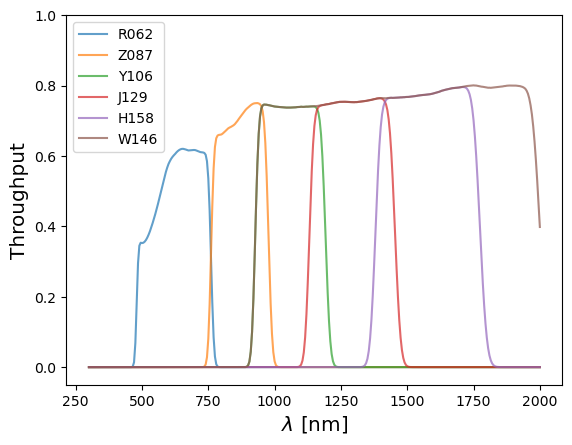

In [3]:
# To get the bandpasses dictionary for the FULL focalplane (same as the galsim.roman.getBandpasses implemenntation).

band_names = [
    "R062",
    "Z087",
    "Y106",
    "J129",
    "H158",
    "W146",
]

for bpname in band_names:
    bandpass = models.getBandpasses(red_limit=2000)[bpname]
    # Get the thermal background for a particular bandpass
    print(f'thermal backgrounds of {bpname}: {models.backgrounds.thermal_backgrounds[bpname]}')
    print(f"effective wavelength of {bpname}: {bandpass.effective_wavelength}\n")
    sky_level = models.getSkyLevel(bandpass)
    print(f"sky level of {bpname}: {sky_level}")
    plt.plot(bandpass.wave_list, bandpass(bandpass.wave_list), label=bpname, alpha=0.7)
    
plt.xlabel(r"$\lambda\ [\rm{nm}]$", size='x-large')
plt.ylabel("Throughput", size='x-large')
plt.ylim([-0.05, 1.])
plt.legend(loc='upper left', fancybox=True)
plt.show()

effective wavelength of SCA:1 in band: H158: 1587.7428756629545
sky level of H158: 5798.685636052505

The zero point flux of SCA:1 33808871245.313347
effective wavelength of SCA:2 in band: H158: 1587.7762624705367
sky level of H158: 6036.873830408924

The zero point flux of SCA:2 35299676137.141235
effective wavelength of SCA:3 in band: H158: 1585.0060929143363
sky level of H158: 5906.582075570944

The zero point flux of SCA:3 34974311151.11777
effective wavelength of SCA:4 in band: H158: 1586.074823198058
sky level of H158: 5900.152138037527

The zero point flux of SCA:4 34786852808.93141
effective wavelength of SCA:5 in band: H158: 1585.5448829439997
sky level of H158: 6050.09095945957

The zero point flux of SCA:5 35693031362.33011
effective wavelength of SCA:6 in band: H158: 1583.44349588402
sky level of H158: 6147.6263512355345

The zero point flux of SCA:6 36675635510.85607
effective wavelength of SCA:7 in band: H158: 1580.5450780649971
sky level of H158: 5843.8994976252525

The 

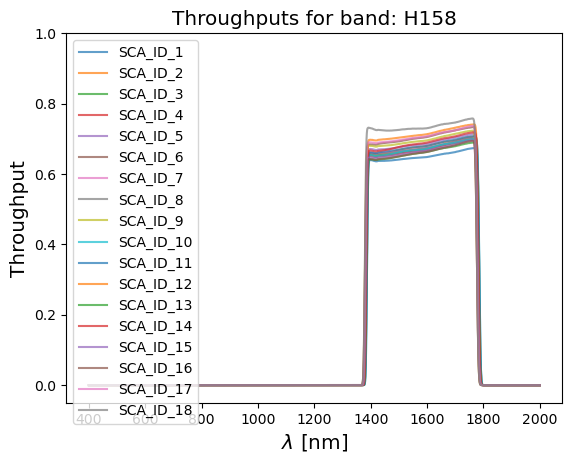

In [4]:
# To get the per-SCA bandpasses dictionaries
bpname = 'H158'

for sca_id in range(1, 19):
    bandpass = models.getBandpasses(red_limit=2000, sca=sca_id)[bpname]
    sky_level = models.getSkyLevel(bandpass)
    print(f"effective wavelength of SCA:{sca_id} in band: {bpname}: {bandpass.effective_wavelength}")
    print(f"sky level of {bpname}: {sky_level}\n")
    plt.plot(bandpass.wave_list, bandpass(bandpass.wave_list), label="SCA_ID_"+str(sca_id), alpha=0.7)

    # Get the zero point flux for a particular bandpass and a particular SCA
    print(f"The zero point flux of SCA:{sca_id}", models.bandpass.get_abflux(bpname, sca_id))

plt.title('Throughputs for band: %s'%(bpname), size='x-large')
plt.xlabel(r"$\lambda\ [\rm{nm}]$", size='x-large')
plt.ylabel("Throughput", size='x-large')
plt.ylim([-0.05, 1.])
plt.legend(loc='upper left', fancybox=True)
plt.show()

***
## 2. PSF
* The functions from ```galsim.roman.roman_psf``` implementation are put into ```psf_utils.py``` and the origianl ```romanisim``` has implemented a wrapper of them, which is now under ```psf.py```
* ```romanisim``` implementation supports calling ```stpsf``` and ```epsf```(CRDS empirical PSF), which is at this moment not supporting create chromatic PSFs.

***
### For discussion: we may want to find a way to cache the ```stpsf``` models at different wavelengths.

***

2026-02-18 17:35:03 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:03 INFO     Creating PSF using stpsf
2026-02-18 17:35:03 INFO     NumExpr defaulting to 12 threads.
2026-02-18 17:35:04 INFO     Using pupil mask 'F062' and detector 'WFI01'.
2026-02-18 17:35:04 INFO     Using pupil mask 'F062' and detector 'WFI01'.
2026-02-18 17:35:04 INFO     Using pupil mask 'F158' and detector 'WFI01'.
2026-02-18 17:35:04 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody
2026-02-18 17:35:04 INFO     Computing wavelength weights using synthetic photometry for F158...
2026-02-18 17:35:05 INFO     Using pupil mask 'F158' and detector 'WFI01'.
2026-02-18 17:35:05 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10
2026-02-18 17:35:05 INFO     Creating optical system model:
2026-02-18 17:35:05 INFO     Initialized OpticalSystem: Roman+WFI
2026-02-18 17:35:05 INFO     Roman Entrance Pupil: Loaded amplitu

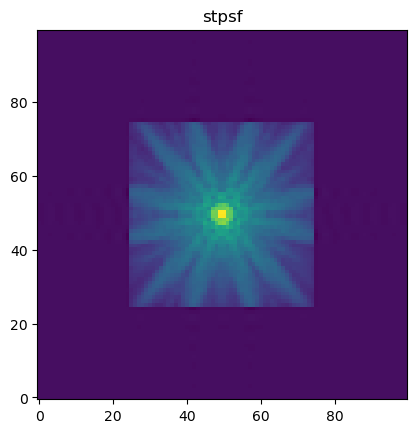

2026-02-18 17:35:10 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:10 INFO     Creating PSF using galsim
2026-02-18 17:35:10 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:10 INFO     Creating PSF using galsim
2026-02-18 17:35:10 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:10 INFO     Creating PSF using galsim
2026-02-18 17:35:10 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:10 INFO     Creating PSF using galsim


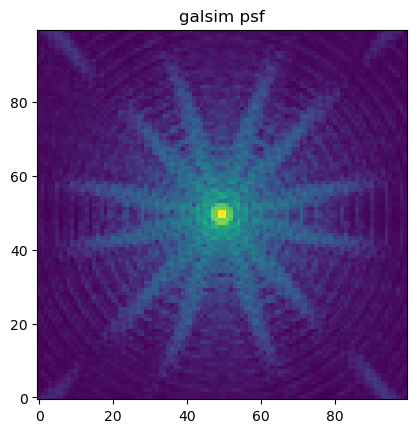

2026-02-18 17:35:11 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:11 INFO     Creating PSF from CRDS reference type epsf
2026-02-18 17:35:11 WARNING  No date has been specified for CRDS EPSF retrieval. Using 2026-01-01T00:00:00.000
2026-02-18 17:35:13 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:13 INFO     Creating PSF from CRDS reference type epsf
2026-02-18 17:35:13 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:13 INFO     Creating PSF from CRDS reference type epsf
2026-02-18 17:35:13 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2026-02-18 17:35:13 INFO     Creating PSF from CRDS reference type epsf


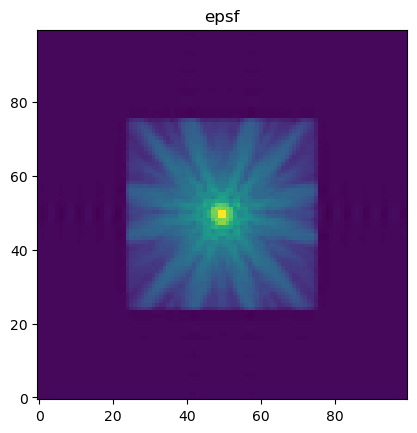

In [5]:
eps = 1e-6
im = galsim.Image(100, 100, scale=0.1, xmin=0, ymin=0)
filter_name = 'F158'

# Create a achromatic PSF object which IS NOT spatially-varing
npix = models.parameters.n_pix
impsfgray = models.psf.make_psf(1, filter_name, psftype='stpsf', chromatic=False)
impsfgray.drawImage(image=im)
log_arr = np.log10(im.array - im.array.min() + eps)
plt.imshow(log_arr, origin='lower')
plt.title('stpsf')
plt.show()

# Create a achromatic PSF object which IS spatially-varing
# A VariablePSF object is returned
impsfgray = models.psf.make_psf(1, filter_name, psftype='galsim', chromatic=False, variable=True)
impsfgray.at_position(npix//2, npix//2).drawImage(image=im)
log_arr = np.log10(im.array - im.array.min() + eps)
plt.imshow(log_arr, origin='lower')
plt.title('galsim psf')
plt.show()

impsfgray = models.psf.make_psf(1, filter_name, psftype='epsf', chromatic=False, variable=True)
impsfgray.at_position(npix//2, npix//2).drawImage(image=im)
log_arr = np.log10(im.array - im.array.min() + eps)
plt.title('epsf')
plt.imshow(log_arr, origin='lower')
plt.show()

# # Create a chromatic PSF object (original galsim.roman implementation)
# impsfchromatic = models.psf.make_psf(1, filter_name, stpsf=False,
#                               chromatic=True)
# print(impsfchromatic)

***

## 3. WCS
* The functions from ```galsim.roman.roman_wcs``` implementation are put into ```wcs_utils.py``` and the origianl ```romanisim``` has implemented a wrapper of them, which is now under ```wcs.py```

<!-- ***
### For discussion: do we want to keep both underlying implementations or only the ```romanisim``` one (currently this will be enabled either ```usecrds``` is True or a distortion model is given)?

*** -->

In [6]:
metadata = copy.deepcopy(models.parameters.default_parameters_dictionary)

# To get the wcs with CRDS distortion model
imwcs = models.wcs.get_wcs(metadata, usecrds=True)
print(imwcs)

# To get the wcs with default distortion model (galsim.roman implementation)
# a 
imwcs = models.wcs.get_wcs(metadata, usecrds=False)
print(imwcs)

romanisim.models.wcs.GWCS(wcs=gWCS, origin=galsim.PositionD(x=0.0, y=0.0))
galsim.GSFitsWCS(_data = ['TAN-SIP', array([2044.0, 2044.0]), array([[-1.5096493108843916e-05, 2.6425124430714086e-05], [-2.6109806399198488e-05, -1.4469421385312164e-05]]), coord.CelestialCoord(coord.Angle(4.700455704456055, coord.radians), coord.Angle(1.1478863255133174, coord.radians)), None, array([[[0.0, 0.0, -6.893454251e-11, 1.922594324e-14, -9.060414279e-18], [1.0, -5.184680748e-10, -4.662192627e-14, -3.034371516e-17, 0.0], [-7.24944964e-10, 1.385072665e-13, -2.021076328e-17, 0.0, 0.0], [6.754756286e-15, 2.040226135e-17, 0.0, 0.0, 0.0], [9.9680995e-19, 0.0, 0.0, 0.0, 0.0]], [[0.0, 1.0, -7.18706293e-10, -2.325030923e-14, -1.648886898e-18], [0.0, -6.328986775e-10, -1.527981825e-14, 3.675101379e-18, 0.0], [-1.819231968e-10, 2.334683425e-14, 2.556983582e-17, 0.0, 0.0], [-1.408413679e-13, 1.866890949e-17, 0.0, 0.0, 0.0], [-2.541109024e-17, 0.0, 0.0, 0.0, 0.0]]]), None])


***
## 4. Read noise
* Implemented as a ```ReadNoise``` class
  - Constructor: ```__init__(self, usecrds=False, metadata=None, image_mod=None, reffiles=None, rng=None, seed=None)```
  - Apply: ```apply(self, img, n_read=1.0)```
* Can switch betwween using default Gaussian noise model and the read noise map from CRDS
***

Default read noise value: 8.5


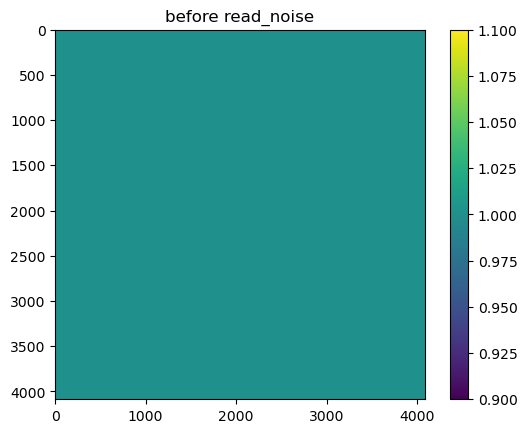

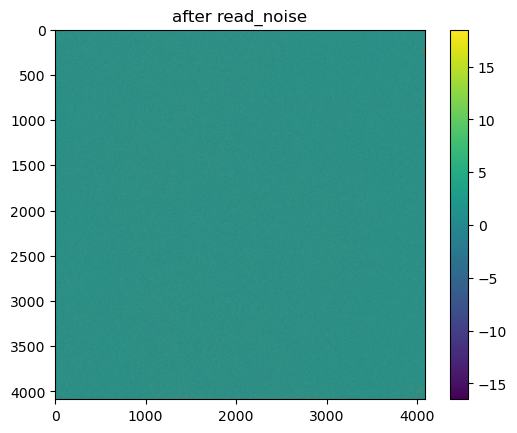

pixel values (mean) =  1.0003738
pixel values (median) =  0.9978815
pixel values (max) =  20291.676
pixel values (min) =  -15332.727


In [7]:
# To get a scalar of default read noise level
print(f"Default read noise value: {models.read_noise}")

# Use CRDS read noise map
read_noise = models.ReadNoise(usecrds=True)

# Need to be applied on a galsim.Image
arr = np.ones((4088, 4088), dtype=np.float32)
image = galsim.Image(arr, dtype=np.float32)

plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
plt.title("before read_noise")
plt.colorbar()
plt.show()

# Apply noise (either reference map from CRDS or the default Gaussian model)
read_noise.apply(img=image)

mean, std = np.mean(image.array), np.std(image.array)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)

plt.title("after read_noise")
plt.colorbar()
plt.show()
print("pixel values (mean) = ", np.median(image.array))
print("pixel values (median) = ", np.mean(image.array))
print("pixel values (max) = ", np.max(image.array))
print("pixel values (min) = ", np.min(image.array))

***

## 5. Saturation
* Implemented as a ```Saturation``` class:
  - Constructor: ```__init__(self, usecrds=False, getdq=False, metadata=None, image_mod=None, reffiles=None, saturation_level=300000)```
  - Apply: ```apply(self, img)```
* There are some subtleties regarding saturation: the CRDS provides a saturation map corresponding to digital saturation levels. However, when simulating very bright sources, we also need to cap the maximum photo-electron counts at the point where the detector response curve begins to plateau.
***
### For discussion: how to simulate and correct saturation (or non-linearity) should be discussed
***

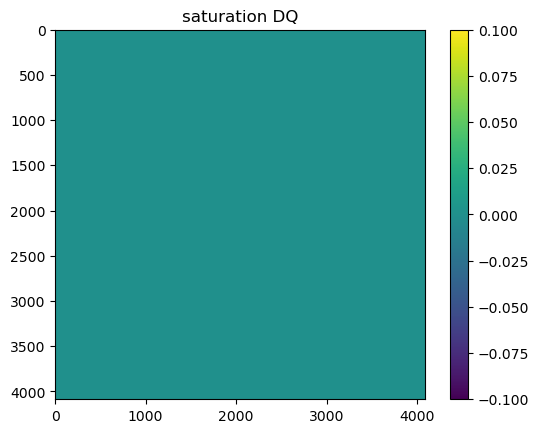

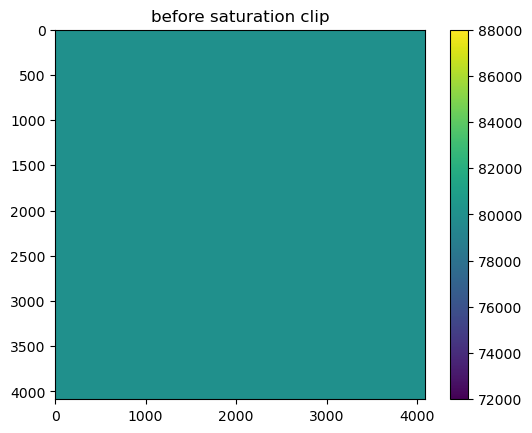

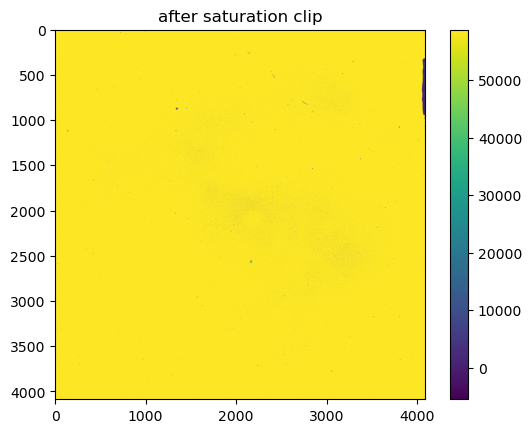

pixel values (mean) =  58711.0
pixel values (median) =  58414.695
pixel values (max) =  58803.0
pixel values (min) =  -5500.0


In [8]:
# Apply digital saturation use CRDS map
saturation = models.Saturation(usecrds=True, getdq=True)

plt.imshow(saturation.dq, vmin=saturation.dq.min(), vmax=saturation.dq.max())
plt.title("saturation DQ")
plt.colorbar()
plt.show()

arr = np.ones((4088, 4088), dtype=np.float32) * 80000.0

plt.imshow(arr, vmin=arr.min(), vmax=arr.max())
plt.title("before saturation clip")
plt.colorbar()
plt.show()

saturation.apply(img=arr)

plt.imshow(arr, vmin=arr.min(), vmax=arr.max())
plt.title("after saturation clip")
plt.colorbar()
plt.show()

print("pixel values (mean) = ", np.median(arr))
print("pixel values (median) = ", np.mean(arr))
print("pixel values (max) = ", np.max(arr))
print("pixel values (min) = ", np.min(arr))

# Apply 'physical' saturation cap to galsim.Image
saturation = models.Saturation(usecrds=False, saturation_level=300000)
arr = np.ones((4088, 4088), dtype=np.float32) * 400000.0
image = galsim.Image(arr, dtype=np.float32)
# plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
# plt.title("before saturation clip")
# plt.colorbar()
# plt.show()

saturation.apply(img=image)
# plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
# plt.title("after saturation clip")
# plt.colorbar()
# plt.show()

# print("pixel values (mean) = ", np.median(image.array))
# print("pixel values (median) = ", np.mean(image.array))
# print("pixel values (max) = ", np.max(image.array))
# print("pixel values (min) = ", np.min(image.array))

***

## 6.Nonlinearity
* Followed the implementation in ```romanisim.nonlinearity```
* Implemented as a ```Nonlinearity``` class:
  - Constructor: ```__init__(self, usecrds=False, reftype="inverselinearity", getdq=False, metadata=None, image_mod=None, reffiles=None, saturation)```
  - Apply: ```apply(self, img, electrons=False, reversed=False)```
* The options for ```reftype``` are: ```linearity``` (for linearity correction), ```inverselinearity``` (for inverse non-linearity correction, e.g. simulate L1 products).
* Can switch between using default second order polynomials (as implemented in ```galsim.roman```) and the (inverse)linearity reference from CRDS:
  - Controlled by ```usecrds (bool)``` parameter

***

Default nonlinearity beta value: -6e-07


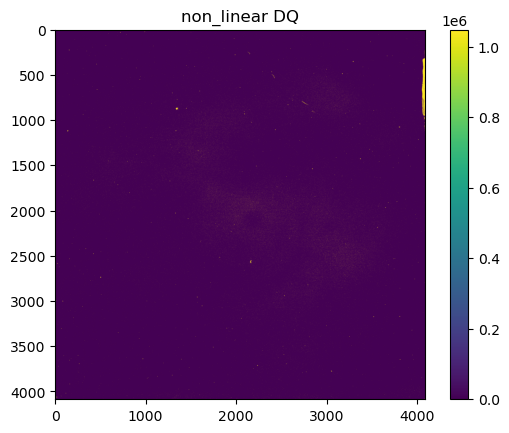

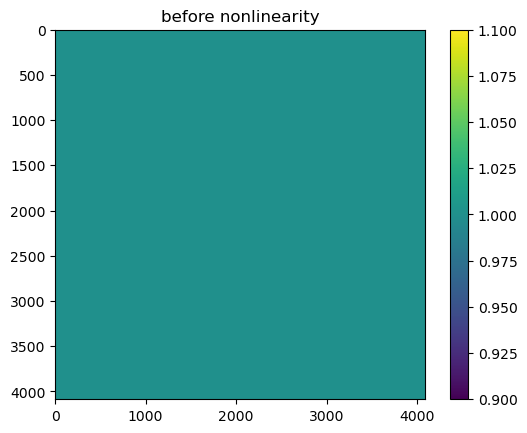

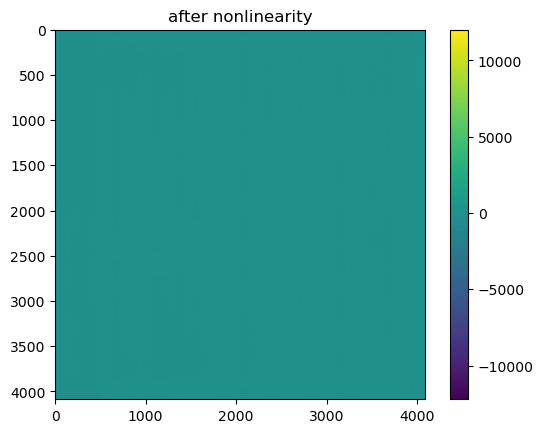

pixel values (mean) =  -93.94476
pixel values (median) =  -94.74158
pixel values (max) =  7.221535e+07
pixel values (min) =  -1.9471924e+07


In [9]:
# To get a scalar of default polynomial parameter: nonlinearity_beta
print(f"Default nonlinearity beta value: {models.nonlinearity_beta}")

non_linear = models.Nonlinearity(usecrds=True, getdq=True)

plt.imshow(non_linear.dq, vmin=non_linear.dq.min(), vmax=non_linear.dq.max())
plt.title("non_linear DQ")
plt.colorbar()
plt.show()


# Applied on a galsim.Image (or a numpy array)
arr = np.ones((4088, 4088), dtype=np.float32)
image = galsim.Image(arr, dtype=np.float32)

plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
plt.title("before nonlinearity")
plt.colorbar()
plt.show()
non_linear.apply(img=image, electrons=False)

mean, std = np.mean(image.array), np.std(image.array)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)

plt.title("after nonlinearity")
plt.colorbar()
plt.show()

print("pixel values (mean) = ", np.median(image.array))
print("pixel values (median) = ", np.mean(image.array))
print("pixel values (max) = ", np.max(image.array))
print("pixel values (min) = ", np.min(image.array))

# # Apply on a numpy array:
# non_linear = models.Nonlinearity(usecrds=True)
# arr = np.ones((4088, 4088), dtype=np.float32)
# non_linear.apply(img=arr)
# mean, std = np.mean(arr), np.std(arr)
# plt.imshow(arr, vmin=mean - std / 2.0, vmax=mean + std / 2.0)
# plt.title("after non_linear")
# plt.colorbar()
# plt.show()

# print("pixel values (mean) = ", np.median(arr))
# print("pixel values (median) = ", np.mean(arr))
# print("pixel values (max) = ", np.max(arr))
# print("pixel values (min) = ", np.min(arr))

# print(non_linear.coeffs.shape)
# for i in range(non_linear.coeffs.shape[0]):
#     print(i, np.mean(non_linear.coeffs[i, :, :]))
#     print(i, np.max(non_linear.coeffs[i, :, :]))
#     print(i, np.min(non_linear.coeffs[i, :, :]))

***

## 7. IPC
* Followed the implementation in ```romanisim.l1```
* Implemented as an ```IPC``` class:
  - Constructor: ```__init__(self, usecrds=False, metadata=None, image_mod=None, reffiles=None)```
  - Apply: ```apply(self, img, edge_treatment=”constant”, fill_value=None)```
* Can switch between using default ipc kernel and the ipc kernel from CRDS

***

### Question: do we want to follow [Chris’ implementation](https://github.com/Roman-HLIS-Cosmology-PIT/romanimpreprocess/blob/d0d89bed96bb95b699c4597bb9a924ce0539eaa0/src/romanimpreprocess/utils/ipc_linearity.py#L43), utilizing pixel-by-pixel ipc kernel (e.g. a 4D numpy array of size (3,3,ny,nx))?

***

Default IPC kernel:
[[0.0021114  0.01669013 0.00221194]
 [0.01890207 0.92087271 0.01880153]
 [0.0021114  0.01628795 0.00201086]]


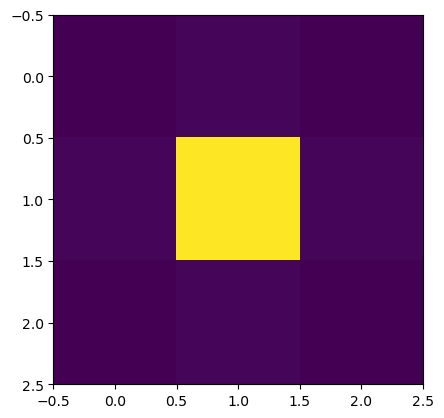

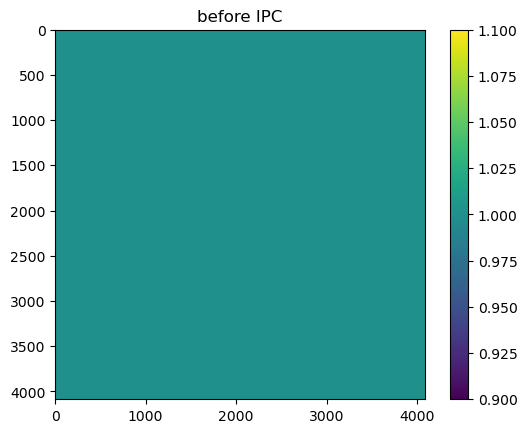

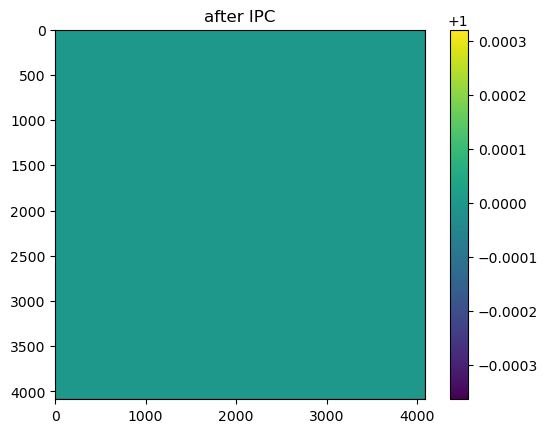

pixel values (mean) =  1.0
pixel values (median) =  0.9999786
pixel values (max) =  1.0
pixel values (min) =  0.95797306


In [10]:
print("Default IPC kernel:")
print(models.ipc_kernel)
plt.imshow(models.ipc_kernel)
plt.show()

IPC = models.IPC(usecrds=True)

# Apply gain on a galsim.Image (or a numpy array)
arr = np.ones((4088, 4088), dtype=np.float32)
image = galsim.Image(arr, dtype=np.float32)

plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
plt.title("before IPC")
plt.colorbar()
plt.show()
IPC.apply(img=image)

mean, std = np.mean(image.array), np.std(image.array)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)

plt.title("after IPC")
plt.colorbar()
plt.show()
print("pixel values (mean) = ", np.median(image.array))
print("pixel values (median) = ", np.mean(image.array))
print("pixel values (max) = ", np.max(image.array))
print("pixel values (min) = ", np.min(image.array))

# # Apply IPC on a numpy array:
# IPC = models.IPC(usecrds=True)
# arr = np.ones((4088, 4088), dtype=np.float32)
# IPC.apply(img=arr)
# mean, std = np.mean(arr), np.std(arr)
# plt.imshow(arr, vmin=mean - std / 2.0, vmax=mean + std / 2.0)
# plt.title("after IPC")
# plt.colorbar()
# plt.show()

# print("pixel values (mean) = ", np.median(arr))
# print("pixel values (median) = ", np.mean(arr))
# print("pixel values (max) = ", np.max(arr))
# print("pixel values (min) = ", np.min(arr))

***

## 8. Gain
* Followed the implementation in ```romanisim.l1```
* Implemented as an ```Gain``` class:
  - Constructor: ```__init__(self, usecrds=False, metadata=None, image_mod=None, reffiles=None)```
  - Apply: ```apply(self, img)```
* Can switch between using default gain value (1.0) and the gain map from CRDS

***

Default gain value: 2.0


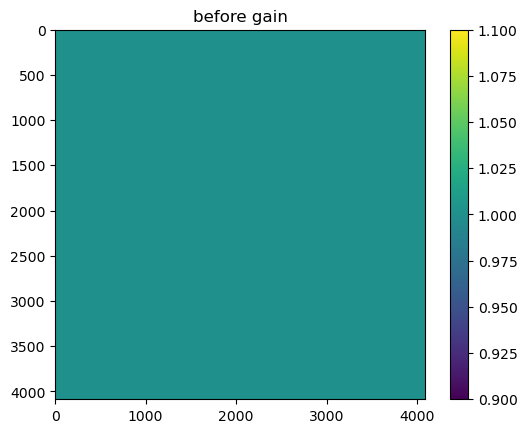

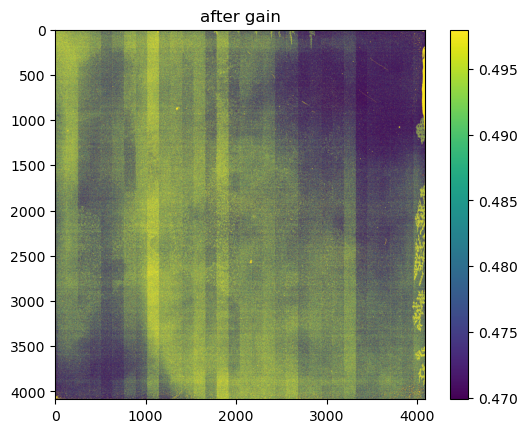

pixel values (mean) =  0.48245728
pixel values (median) =  0.48393387
pixel values (max) =  0.9999994
pixel values (min) =  0.3333348


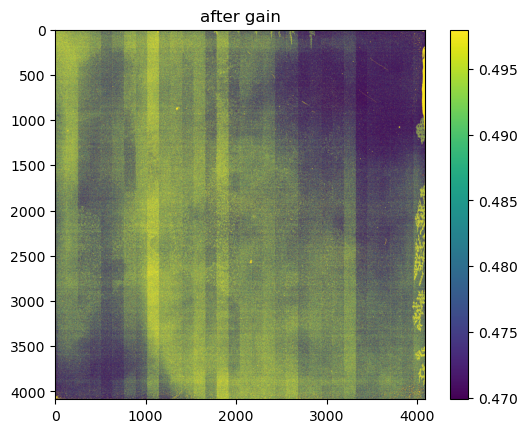

In [11]:
# To get a scalar of default gain value
print(f"Default gain value: {models.gain}")

gain = models.Gain(usecrds=True)

# Apply gain on a galsim.Image
arr = np.ones((4088, 4088), dtype=np.float32)
image = galsim.Image(arr, dtype=np.float32)

plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
plt.title("before gain")
plt.colorbar()
plt.show()

gain.apply(img=image)

mean, std = np.mean(image.array), np.std(image.array)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)

plt.title("after gain")
plt.colorbar()
plt.show()
print("pixel values (mean) = ", np.median(image.array))
print("pixel values (median) = ", np.mean(image.array))
print("pixel values (max) = ", np.max(image.array))
print("pixel values (min) = ", np.min(image.array))

# Apply gain on a numpy array:
arr = np.ones((4088, 4088), dtype=np.float32)
gain.apply(img=arr)
mean, std = np.mean(arr), np.std(arr)
plt.imshow(arr, vmin=mean - std / 2.0, vmax=mean + std / 2.0)
plt.title("after gain")
plt.colorbar()
plt.show()

***

## 9. Dark current
* Followed the implementation in ```romanisim.image```
* Default dark current rate is updated from roman-techinical-information summary table (column: “Dark Current - Median”)
* Implemented as an ```DarkCurrent``` class:
  - Constructor: ```__init__(self, usecrds=False, getdq=False, metadata=None, image_mod=None, reffiles=None, rng=None, seed=None)```
  - Apply: ```apply(self, img, exptime)```
* Can switch between using default dark current level and the dark current slope map from CRDS
  - Use ```dark_slop``` map, scaled by ```gain``` map

***

default dark current value: 0.018


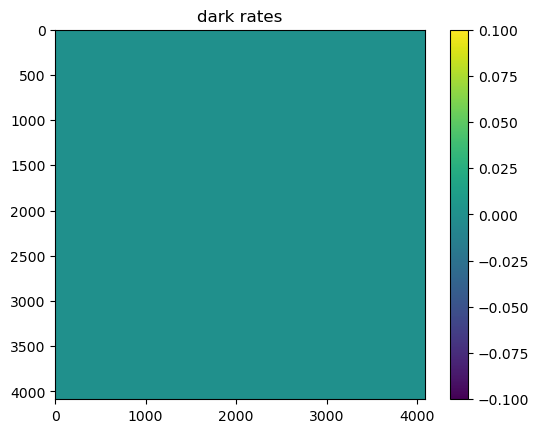

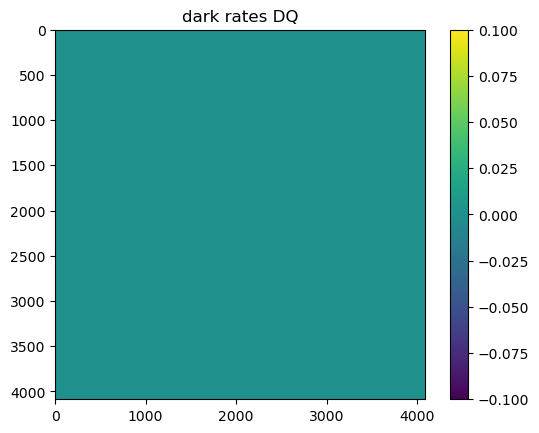

dark_rate values (mean) =  0.0
dark_rate values (median) =  0.0
dark_rate values (max) =  0.0
dark_rate values (min) =  0.0


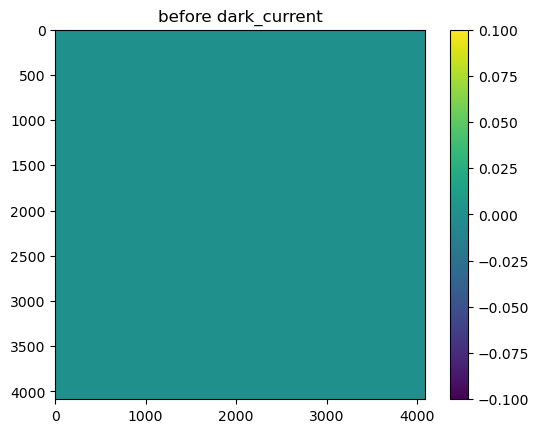

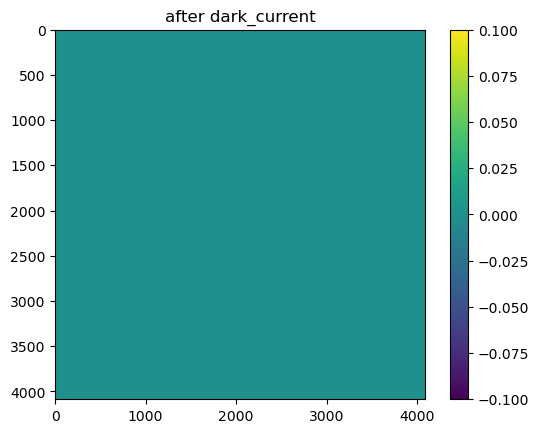

pixel values (mean) =  0.0
pixel values (median) =  0.0
pixel values (max) =  0.0
pixel values (min) =  0.0
True


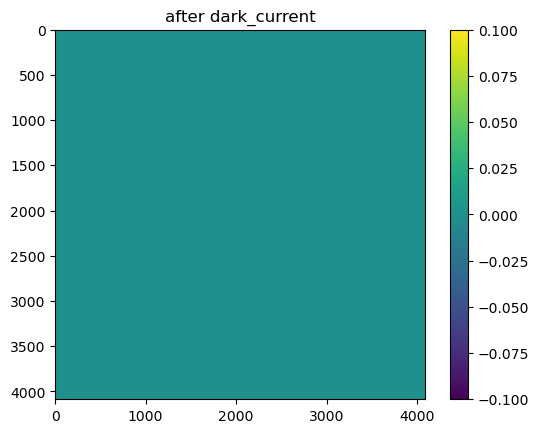

In [12]:
# To get a scalar of default dark current rate
print(f"default dark current value: {models.dark_current}")

dark_current = models.DarkCurrent(usecrds=True, getdq=True)

plt.imshow(dark_current.dark_rate, vmin=dark_current.dark_rate.min(), vmax=dark_current.dark_rate.max())
plt.title("dark rates")
plt.colorbar()
plt.show()

plt.imshow(dark_current.dq, vmin=dark_current.dq.min(), vmax=dark_current.dq.max())
plt.title("dark rates DQ")
plt.colorbar()
plt.show()

print("dark_rate values (mean) = ", np.median(dark_current.dark_rate))
print("dark_rate values (median) = ", np.mean(dark_current.dark_rate))
print("dark_rate values (max) = ", np.max(dark_current.dark_rate))
print("dark_rate values (min) = ", np.min(dark_current.dark_rate))

# Need to be applied on a galsim.Image
arr = np.zeros((4088, 4088), dtype=np.float32)
image = galsim.Image(arr, dtype=np.float32)


plt.imshow(image.array, vmin=image.array.min(), vmax=image.array.max())
plt.title("before dark_current")
plt.colorbar()
plt.show()

dark_current.apply(img=image, exptime=100.0)

mean, std = np.mean(image.array), np.std(image.array)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)

plt.title("after dark_current")
plt.colorbar()
plt.show()
print("pixel values (mean) = ", np.median(image.array))
print("pixel values (median) = ", np.mean(image.array))
print("pixel values (max) = ", np.max(image.array))
print("pixel values (min) = ", np.min(image.array))

# print(dark_current.dark_rate)
are_all_same = len(np.unique(dark_current.dark_rate)) == 1
print(are_all_same)

# Apply gain on a numpy array:
arr = np.zeros((4088, 4088), dtype=np.float32)
dark_current.apply(img=arr, exptime=100.0)
mean, std = np.mean(arr), np.std(arr)
plt.imshow(image.array, vmin=mean - std / 2.0, vmax=mean + std / 2.0)
plt.title("after dark_current")
plt.colorbar()
plt.show()

***

# Questions & TODOs
<!-- * Make decisions on the interfaces. -->
<!-- * Propagate the DQ maps. -->
* Persistence module: should we implement roman-technical-information model option?
  - in ```galsim.roman``` we have linear and Fermi models (```A* (x/x0)**a * (t/1000.)**(-r) / (exp( -(x-x0)/dx ) +1. )```)
  - Fitted exponential model from roman-technical-information: ```a*exp(-b*x)+d*exp(-e*x)+c```
* Flat field module
***